In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from lightly.data import LightlyDataset, SimCLRCollateFunction, collate

In [2]:
num_workers = 8
batch_size = 256
seed = 1
max_epochs = 60
input_size = 128
num_ftrs = 32

In [3]:
pl.seed_everything(seed)

Global seed set to 1


1

In [4]:
#!git clone https://github.com/alexeygrigorev/clothing-dataset.git

In [5]:
!ls

'A (copy).jpg'	    B.jpg		   lightning_logs   ViewGenerator.py
 A.jpg		    CloseViews		   main.ipynb	    Views
 Augmentations	    config.yaml		   MapLoader.py     Weights
 Augmentations.py   D.jpg		   Maps
'B (copy).jpg'	    E.jpg		   output3.png
 BingMaps.py	    Lightly_SimCLR.ipynb   __pycache__


In [6]:
path_to_data = "./Views"


In [7]:
collate_fn = SimCLRCollateFunction(input_size=input_size, random_gray_scale = 0.0, vf_prob=0.0, rr_prob=0.5, rr_degrees=(-5, 5))

# We create a torchvision transformation for embedding the dataset after
# training
test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Grayscale(num_output_channels=3),
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=collate.imagenet_normalize["mean"],
            std=collate.imagenet_normalize["std"],
        ),
    ]
)

dataset_train_simclr = LightlyDataset(input_dir=path_to_data)

dataset_test = LightlyDataset(input_dir=path_to_data, transform=test_transforms)

dataset_close_views = LightlyDataset(input_dir='./CloseViews', transform=test_transforms)


dataloader_train_simclr = torch.utils.data.DataLoader(
    dataset_train_simclr,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True,
    num_workers=num_workers,
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

dataloader_close_views = torch.utils.data.DataLoader(
    dataset_close_views,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [8]:
from lightly.loss import NTXentLoss
from lightly.models.modules.heads import SimCLRProjectionHead


class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), 
            lr          = self.config['learning rate'], 
            momentum    = self.config['momentum'], 
            weight_decay= self.config['weight decay']
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, self.config['max epochs'])
        return [optim], [scheduler]

In [24]:
model = SimCLRModel()
trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="gpu")
trainer.fit(model, dataloader_train_simclr)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.022    Total estimated

In [15]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, label, fnames in dataloader:
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames


#model.to('cpu').eval()
embeddings, filenames = generate_embeddings(model, dataloader_test)

In [16]:
def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array"""
    img = Image.open(filename)
    return np.asarray(img)


def plot_knn_examples(embeddings, filenames, n_neighbors=3, num_examples=6, path_to_data=path_to_data):
    """Plots multiple rows of random images with their nearest neighbors"""
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get 5 random samples
    samples_idx = np.array(range(num_examples))#np.random.choice(len(indices), size=num_examples, replace=False)

    names = {}

    # loop through our randomly picked samples
    for idx in samples_idx:
        names[filenames[idx]] = []
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(path_to_data, filenames[neighbor_idx])
            
            names[filenames[idx]].append(filenames[neighbor_idx])
            
            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f"d={distances[idx][plot_x_offset]:.3f}")
            #ax.set_title(filenames[idx])
            # let's disable the axis
            plt.axis("off")

    return names

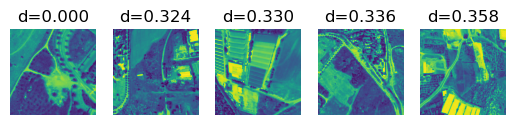

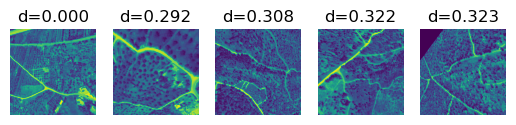

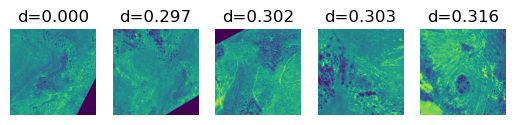

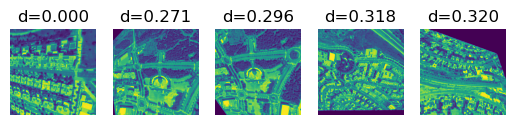

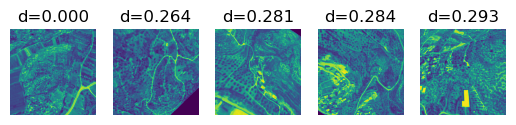

In [17]:
names = plot_knn_examples(embeddings, filenames, 5, 5)


In [18]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
path_to_data = "./CloseViews"

In [19]:
import os

# folder path
dir_path = path_to_data
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 2172


In [20]:
embeddings_close_views, filenames_close_views = generate_embeddings(model, dataloader_close_views)

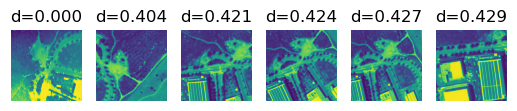

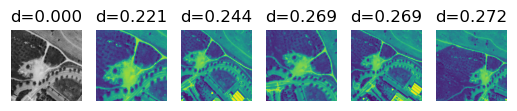

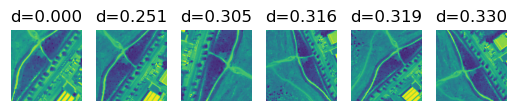

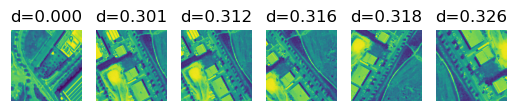

In [21]:
names = plot_knn_examples(embeddings_close_views, filenames_close_views, 6, 4, path_to_data='./CloseViews')

In [12]:
torch.save(model.state_dict(), './Weights/model_40_epochs.py')

In [13]:
model.load_state_dict(torch.load('./Weights/model_40_epochs.py'))

<All keys matched successfully>

In [117]:
from PIL import Image
img = Image.open('./A.jpg')

In [118]:
tensor = test_transforms(img)
model((tensor.unsqueeze(0)))

tensor([[-0.5236,  0.9064,  0.5445,  1.5318, -1.0104, -2.2771,  0.0152, -0.4114,
          1.8467, -0.3666, -0.4585,  0.2459,  0.6044,  0.0065,  0.3139,  0.3202,
         -0.5983,  0.9936,  0.5335, -0.9777,  0.0617,  0.1036, -1.0229,  0.4355,
         -0.9590,  0.9480, -1.5483, -0.2754,  0.9245,  0.1710, -0.7297,  0.0751,
         -0.1453,  1.5827,  0.3573, -0.3089, -0.4460, -1.3165,  0.8672, -0.1494,
          0.9098, -0.5089, -1.1386, -0.5341,  0.8294, -0.2986, -0.4757, -1.2146,
          0.0503, -0.3484, -0.0163,  0.0971, -1.2614,  1.4701, -0.4174, -0.1864,
          0.9067, -0.6382,  0.6261,  0.7409, -0.7945, -0.6354, -0.0844, -1.6903,
         -0.4968,  0.2495,  0.5065,  0.0365, -0.5502, -0.0682, -1.3803, -0.6177,
          0.2673, -0.0669, -0.9974,  1.0317,  0.9636,  0.0710,  1.6113, -1.7900,
          0.4736, -1.1380, -0.3777, -1.0317, -0.0508,  0.1473, -0.1273, -0.4990,
         -1.3611, -0.4697, -0.8247,  1.2766, -0.9804, -1.1474,  0.4397,  0.9372,
         -0.0597,  0.9600, -

In [119]:
if backbone_name == 'resnet_18':
            resnet_net = torchvision.models.resnet18(pretrained=True)
            modules = list(resnet_net.children())[:-2]
            backbone = nn.Sequential(*modules)

NameError: name 'backbone_name' is not defined

In [23]:
names

{'A.jpg': ['A.jpg',
  'VIEW-31_883625202781012-34_9575209540462-163_85508270792772-0_0-0_0-n2_951294444689366.jpeg',
  'VIEW-31_88348138507149-34_9585038661531-165_95639343998806-0_0-0_0-2_179629907405685.jpeg',
  'VIEW-31_883756166082396-34_95835731659253-177_78843287371524-0_0-0_0-1_8706234744608503.jpeg',
  'VIEW-31_883868856350077-34_958276875680504-181_9297481283681-0_0-0_0-2_0789443746849186.jpeg',
  'VIEW-31_883107934376838-34_95946059801287-141_3489489157125-0_0-0_0-2_166279121328758.jpeg'],
 'B.jpg': ['B.jpg',
  'VIEW-31_88381075463041-34_95769897997623-120_46346709130174-0_0-0_0-1_467643005037468.jpeg',
  'VIEW-31_88415575207868-34_95793511769674-180_5867644008879-0_0-0_0-1_7147172692503005.jpeg',
  'VIEW-31_883744188396236-34_95782617149169-146_06634501007974-0_0-0_0-2_1704949796055226.jpeg',
  'VIEW-31_884021766505775-34_95796475351404-199_03947326380674-0_0-0_0-1_5194449155227039.jpeg',
  'VIEW-31_8834974851211-34_95742799371301-197_2738974191848-0_0-0_0-1_3132324904762331